# Time Series Analysis for Sales Forecasting

**Goal:** Can we develop a reliable time series model to forecast future sales volumes and identify seasonal patterns in the Brazilian e-commerce market?

Notebook Contents

- SARIMA modeling with hyperparameter tuning
- Residual diagnostics (including Ljung-Box test)
- Confidence intervals in forecasts
- Benchmark with seasonal naive forecast
- Evaluation using MAE, RMSE, MAPE

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings("ignore")


## 1. Data

Filter for only 'delivered' orders and aggregate the data into daily order counts.  

In [3]:

orders = pd.read_csv('../Dataset/raw/olist_orders_dataset.csv', parse_dates=['order_purchase_timestamp'])
order_items = pd.read_csv('../Dataset/raw/olist_order_items_dataset.csv')

# Filter delivered orders
delivered_orders = orders[orders['order_status'] == 'delivered']
merged = pd.merge(delivered_orders[['order_id', 'order_purchase_timestamp']],
                  order_items[['order_id', 'price']],
                  on='order_id')
merged['order_date'] = merged['order_purchase_timestamp'].dt.date

# Aggregate daily order count
daily_summary = merged.groupby('order_date').agg(order_count=('order_id', 'nunique')).reset_index()
daily_summary['order_date'] = pd.to_datetime(daily_summary['order_date'])
daily_summary.set_index('order_date', inplace=True)
daily_summary = daily_summary.asfreq('D', fill_value=0)


## 2. Train-Test Split

Split the data into training and test sets, using the last 60 days as the test period.  

In [4]:

train = daily_summary.iloc[:-60]
test = daily_summary.iloc[-60:]


## 3. SARIMA Hyperparameter Tuning

Test multiple SARIMA model configurations and select the one with the lowest AIC.

In [5]:

best_aic = np.inf
best_order = None
best_seasonal_order = None

for order in [(1,1,1), (2,1,2)]:
    for seasonal_order in [(1,1,1,7), (1,0,1,7)]:
        try:
            model = SARIMAX(train['order_count'], order=order, seasonal_order=seasonal_order)
            results = model.fit(disp=False)
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = order
                best_seasonal_order = seasonal_order
        except:
            continue

print(f"Best SARIMA Order: {best_order}, Seasonal Order: {best_seasonal_order}, AIC: {best_aic:.2f}")


Best SARIMA Order: (1, 1, 1), Seasonal Order: (1, 1, 1, 7), AIC: 6771.07


## 4. Fit best model and forecast

Fit the SARIMA model on the training data to generate forecasts for the test period.  
Also generate confidence intervals to estimate the uncertainty of the predictions.

In [6]:

final_model = SARIMAX(train['order_count'], order=best_order, seasonal_order=best_seasonal_order)
final_results = final_model.fit(disp=False)
forecast = final_results.get_forecast(steps=60)
predicted = forecast.predicted_mean
conf_int = forecast.conf_int()


## 5. Forecast Performance

Calculate MAE, RMSE, and MAPE to quantify model accuracy.  

In [7]:

mae = mean_absolute_error(test['order_count'], predicted)
rmse = np.sqrt(mean_squared_error(test['order_count'], predicted))
mape = mean_absolute_percentage_error(test['order_count'], predicted)
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2%}")


MAE: 63.84, RMSE: 77.12, MAPE: 71.21%


## 6. Forecast vs Actual

Visualize the SARIMA forecast alongside the actual sales data.  

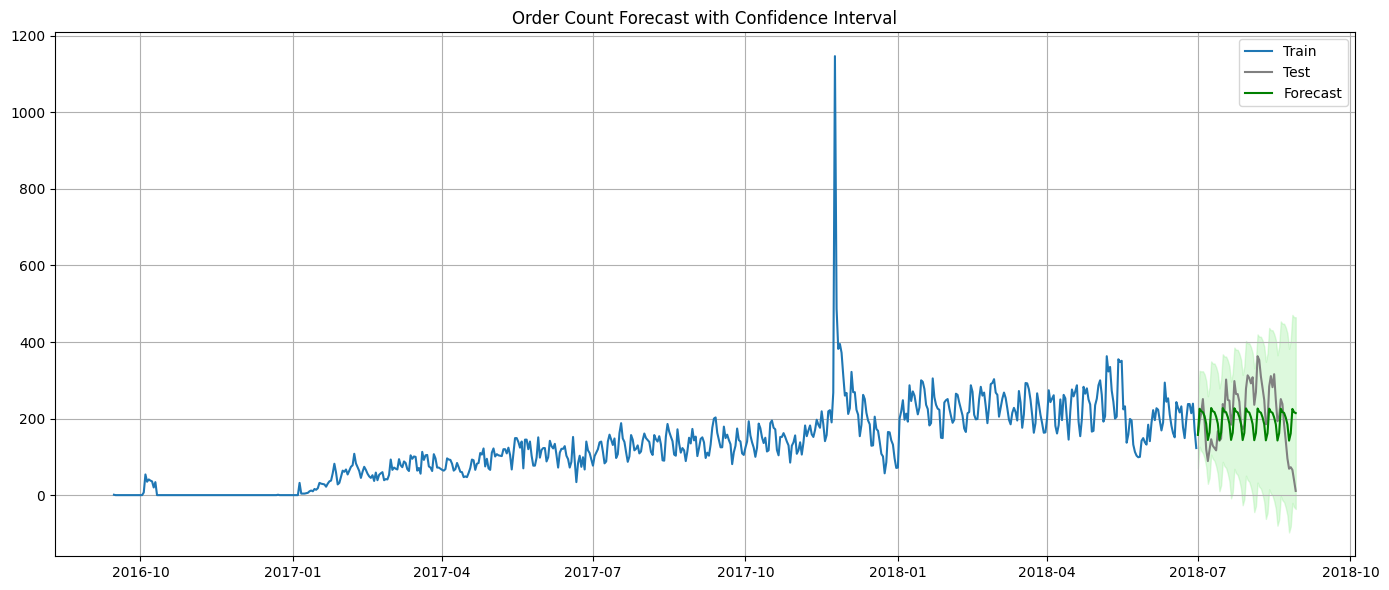

In [8]:

plt.figure(figsize=(14, 6))
plt.plot(train.index, train['order_count'], label='Train')
plt.plot(test.index, test['order_count'], label='Test', color='gray')
plt.plot(predicted.index, predicted, label='Forecast', color='green')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='lightgreen', alpha=0.3)
plt.title('Order Count Forecast with Confidence Interval')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 7. Residual Diagnostics (Ljung-Box Test)

Apply the Ljung-Box test to the residuals to check for remaining autocorrelation.  

In [9]:

residuals = final_results.resid
ljung_box_pvalue = acorr_ljungbox(residuals, lags=[10], return_df=True)['lb_pvalue'].values[0]
print(f"Ljung-Box p-value: {ljung_box_pvalue:.4f}")


Ljung-Box p-value: 0.9130


## 8. Benchmark - Seasonal Naive Forecast

Implement a simple seasonal naive model that repeats the sales pattern from the prior week. 

In [10]:

seasonal_naive = train['order_count'][-7:].repeat(60 // 7 + 1)[:60].values
mae_naive = mean_absolute_error(test['order_count'], seasonal_naive)
rmse_naive = np.sqrt(mean_squared_error(test['order_count'], seasonal_naive))
mape_naive = mean_absolute_percentage_error(test['order_count'], seasonal_naive)

print(f'Seasonal Naive MAE: {mae_naive:.2f}, RMSE: {rmse_naive:.2f}, MAPE: {mape_naive:.2%}')



Seasonal Naive MAE: 58.57, RMSE: 68.67, MAPE: 51.57%


## 9. Facebook Prophet

Compare SARIMA with a state-of-the-art model: Facebook Prophet.
Prophet handles seasonality and holiday effects automatically and often works well on e-commerce data.


In [11]:

from prophet import Prophet
from prophet.diagnostics import performance_metrics, cross_validation

# data for Prophet
prophet_df = daily_summary.reset_index()[['order_date', 'order_count']].rename(
    columns={'order_date': 'ds', 'order_count': 'y'}
)

#  fit Prophet model
prophet = Prophet(weekly_seasonality=True, daily_seasonality=False)
prophet.fit(prophet_df[:-60])  # Train on same training period

#  future dataframe and forecast
future = prophet.make_future_dataframe(periods=60)
forecast = prophet.predict(future)

#  predicted values
forecast_test = forecast[['ds', 'yhat']].set_index('ds').iloc[-60:]
actual_test = daily_summary.iloc[-60:]['order_count']

# Evaluate 
mae_prophet = mean_absolute_error(actual_test, forecast_test['yhat'])
rmse_prophet = np.sqrt(mean_squared_error(actual_test, forecast_test['yhat']))
mape_prophet = mean_absolute_percentage_error(actual_test, forecast_test['yhat'])

print(f"Prophet MAE: {mae_prophet:.2f}, RMSE: {rmse_prophet:.2f}, MAPE: {mape_prophet:.2%}")


15:13:12 - cmdstanpy - INFO - Chain [1] start processing
15:13:12 - cmdstanpy - INFO - Chain [1] done processing


Prophet MAE: 62.42, RMSE: 76.73, MAPE: 73.63%


## 10. Plot Prophet Forecast vs Actual


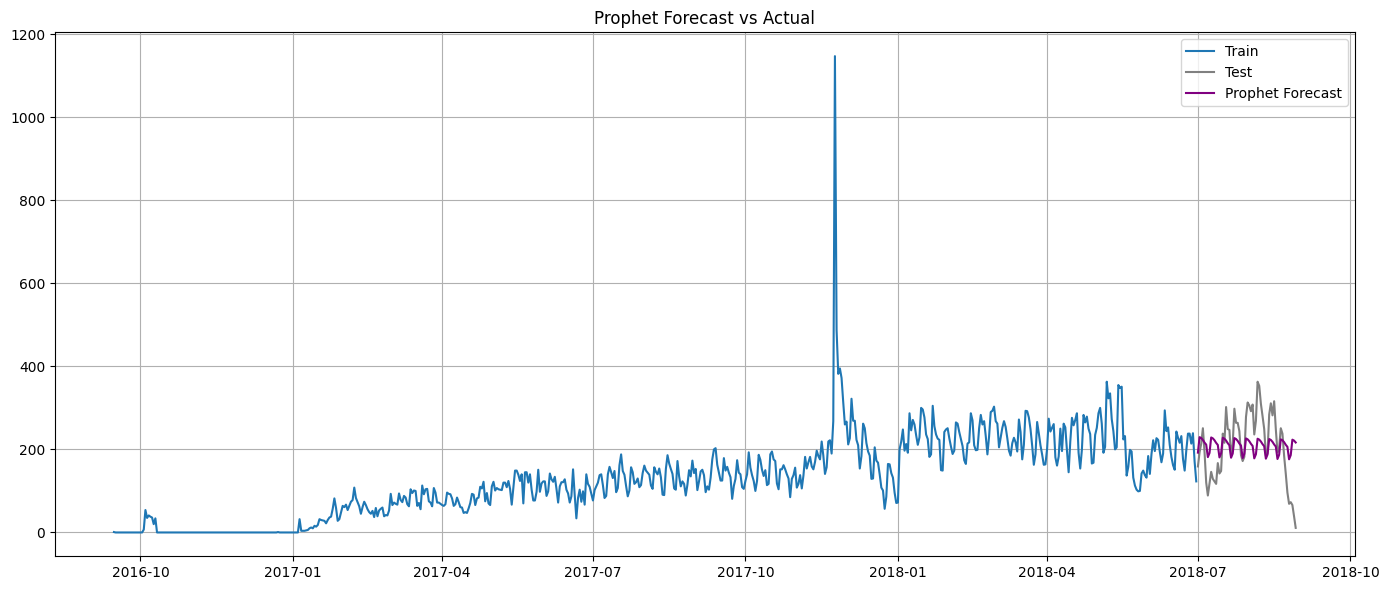

In [12]:
plt.figure(figsize=(14,6))
plt.plot(train.index, train['order_count'], label='Train')
plt.plot(test.index, test['order_count'], label='Test', color='gray')
plt.plot(forecast_test.index, forecast_test['yhat'], label='Prophet Forecast', color='purple')
plt.title('Prophet Forecast vs Actual')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Summary


| Model            | MAE    | RMSE    | MAPE    |
|------------------|--------|---------|---------|
| SARIMA         | 63.84  | 77.12   | 71.21% |
| Seasonal Naive | 58.57  | 68.67   | 51.57% |
| Prophet        | 62.42  | 76.73   | 73.63% |

Seasonal naive is still the best performer.
As compared to SARIMA and Prophet models, the naive forecast with repeated weekly patterns has the lowest MAE, RMSE, and MAPE.

SARIMA and Prophet were able to capture seasonality, but their relative errors (MAPE ~70%) are high which means, they need improvement (e.g., adding holidays, promotions, or external variables).

Residuals passed diagnostics (Ljung-Box), SARIMA errors are not autocorrelated.


## Future Work and Recommendations

 **1. Incorporate Holiday and Promotion Effects**  

  Sales volumes are often influenced by holidays, marketing campaigns, and seasonal promotions.  
  Adding holiday regressors (especially in Prophet) or external features might improve model accuracy during peak events.

 **2. Add External Covariates**  

  Including variables such as product category, payment type, shipping delays can help capture additional demand variability.

 **3. Improve Data Preprocessing**  

  Smoothing or capping extreme outliers in order counts, or modeling sales at a weekly or monthly frequency to reduce noise.

 **4. Explore Alternative Models**  

  Try machine learning approaches such as XGBoost, LightGBM, or LSTM neural networks to model complex, nonlinear patterns.

 **5. Implement Rolling Cross-Validation**  

  Use a rolling forecast origin or time series cross-validation to more robustly evaluate model generalizability across multiple time windows.

 **6. Perform Hyperparameter Tuning with Grid Search or Auto-ARIMA**  

  Automating parameter selection might help identify better-fitting models and avoid manual trial-and-error.